In [1]:
import pandas as pd
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

In [2]:
cleaned = pd.read_csv('datasets/cleaned_Izends_Data_Thru201712_ver5.csv',index_col=0)

/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cleaned_loss_des = pd.read_csv('hashed_cleaned_loss_desc_from_5_ipynb.csv',index_col=0)
# changing dtype of hashed_loss_desc_padded column
cleaned_loss_des['hashed_loss_desc_padded'] = cleaned_loss_des['hashed_loss_desc_padded'].apply(lambda x: np.fromstring(x[1:-1],dtype='int32',sep=' '))

In [4]:
cleaned_combined = pd.merge(cleaned,cleaned_loss_des[['EstimateTotal_bins','hashed_loss_desc_padded']],left_index=True,right_index=True)

In [5]:
cleaned_combined.shape

(766408, 28)

In [6]:
cleaned_combined.columns

Index(['DisplayName', 'DivisionName', 'City', 'Zip', 'State', 'LossYearMo',
       'StartedFlag', 'CommOrRes', 'NoteCount', 'PhotoCount', 'JobCount',
       'ClaimCount', 'EstimateTotal', 'PolicyHolderType', 'LossDescription',
       'Estimate_NetClaim', 'Estimate_MaterialSaleTax', 'Estimate_OverHead',
       'Estimate_Profit', 'Estimate_PctOverhead', 'Estimate_PctProfit',
       'Estimate_Deductible', 'Estimate_BaseSvcCharge',
       'CleanAddressFranchisorID', 'CleanAddressContactID', 'LossMo',
       'EstimateTotal_bins', 'hashed_loss_desc_padded'],
      dtype='object')

# Defining X and Y

In [7]:
X1 = cleaned_combined[['DisplayName', 'DivisionName','LossMo','CommOrRes','PolicyHolderType','NoteCount','PhotoCount','JobCount','ClaimCount','LossYearMo']]
X2 = cleaned_combined['hashed_loss_desc_padded']
y = cleaned_combined['EstimateTotal_bins']

# Getting Dummies

In [8]:
X1_dummies = pd.get_dummies(X1,sparse=True)

In [9]:
all_data = pd.merge(X1_dummies,pd.DataFrame(X2),left_index=True,right_index=True)
all_data['EstimateTotal_bins'] = y

# Splitting data

In [10]:
test2017=all_data[all_data["LossYearMo"].apply(lambda all_data:all_data>=201701)]
learning=all_data[all_data["LossYearMo"].apply(lambda all_data:all_data<201701)]

In [11]:
learning_x = learning[learning.columns.difference(['LossYearMo','EstimateTotal_bins'])]
learning_y = learning['EstimateTotal_bins']
learning_y_dummies = pd.get_dummies(learning_y,sparse=True)

In [12]:
test2017_x1 = test2017[test2017.columns.difference(['LossYearMo','EstimateTotal_bins','hashed_loss_desc_padded'])]
test2017_x2 = test2017['hashed_loss_desc_padded']
test2017_y = test2017['EstimateTotal_bins']
test2017_y_dummies = pd.get_dummies(test2017_y,sparse=True)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(learning_x, learning_y_dummies, test_size=0.33, random_state=42)

In [14]:
X1_train = X_train[X_train.columns.difference(['hashed_loss_desc_padded'])]
X2_train = X_train['hashed_loss_desc_padded']

In [15]:
X1_val = X_val[X_val.columns.difference(['hashed_loss_desc_padded'])]
X2_val = X_val['hashed_loss_desc_padded']

# Load Model

In [17]:
from keras.models import load_model
model = load_model('datasets/saved_models/7a_combined_model_new_arch_seq_classifier_tabular_features_10bins.h5')

Using TensorFlow backend.


# Calculating Valid Accuracy

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
valid_preds_proba = model.predict({'input1':X1_val,'input2':np.stack(X2_val, axis=0)})

In [27]:
valid_preds = np.argmax(valid_preds_proba,axis=1)

In [28]:
mapping_dict = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j'}

In [29]:
valid_preds_names = list(pd.Series(valid_preds).map(mapping_dict))

In [30]:
max_probability = np.max(valid_preds_proba,axis=1)

### Getting y_val actual classes

In [31]:
val_df = y_val.copy()

In [32]:
val_df['actual'] = y[y.index.isin(y_val.index)]

In [33]:
accuracy_score(valid_preds_names, list(val_df['actual']))

0.24308394967501984

# Valid_df

In [34]:
val_df['valid_preds_names'] = valid_preds_names

In [35]:
val_df['max_probability'] = max_probability

# Thresh Accuracy df - valid df

In [36]:
result_df = pd.DataFrame(columns=['thresh_i','thresh_i+1','no_of_preds','total_preds','pct_of_preds','accuracy'])
# total_rows = 0
# total_correct_rows = 0
# total_incorrect_rows = 0
for thresh in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print("\n", thresh)
    temp_df = pd.DataFrame(columns=['thresh_i','thresh_i+1','no_of_preds','total_preds','pct_of_preds','accuracy'])
    a = val_df[(val_df['max_probability'] >= thresh) & (val_df['max_probability'] < (thresh + 0.1))]
    correct_rows = len(a[a['actual'] == a['valid_preds_names']])
    incorrect_rows = len(a[a['actual'] != a['valid_preds_names']])
    pct_of_preds = (a.shape[0]/val_df.shape[0]) * 100
    acc = accuracy_score(list(a['actual']),list(a['valid_preds_names']))*100
    
#     print(correct_rows, incorrect_rows, len(a), \
#           accuracy_score(list(a['EstimateTotal_bins']),list(a['test2017_preds_names']))*100)
#     total_rows += len(a)
#     total_correct_rows += correct_rows
#     total_incorrect_rows += incorrect_rows
#     print (total_correct_rows, total_incorrect_rows, total_rows)

    temp_df.at[0,'thresh_i'] = thresh
    temp_df.at[0,'thresh_i+1'] = thresh + 0.1
    temp_df.at[0,'correct_preds'] = correct_rows
    temp_df.at[0,'incorrect_preds'] = incorrect_rows
    temp_df.at[0,'no_of_preds'] = a.shape[0]
    temp_df.at[0,'total_preds'] = test2017.shape[0]
    temp_df.at[0,'pct_of_preds'] = pct_of_preds
    temp_df.at[0,'accuracy'] = acc
    result_df = result_df.append(temp_df)
#     break


 0.1


/home/ambuj/izenda_fullcycle/environment/env/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)



 0.2

 0.3

 0.4

 0.5

 0.6

 0.7

 0.8

 0.9


In [37]:
result_df

,accuracy,correct_preds,incorrect_preds,no_of_preds,pct_of_preds,thresh_i,thresh_i+1,total_preds
0,16.3335,13881.0,71104.0,84985,51.4789,0.1,0.2,266145
0,23.748,12249.0,39330.0,51579,31.2435,0.2,0.3,266145
0,35.1345,4441.0,8199.0,12640,7.65657,0.3,0.4,266145
0,45.532,2833.0,3389.0,6222,3.76892,0.4,0.5,266145
0,53.6128,1714.0,1483.0,3197,1.93655,0.5,0.6,266145
0,64.1316,1248.0,698.0,1946,1.17877,0.6,0.7,266145
0,71.9529,1039.0,405.0,1444,0.87469,0.7,0.8,266145
0,81.8317,1099.0,244.0,1343,0.81351,0.8,0.9,266145
0,93.9341,1626.0,105.0,1731,1.04854,0.9,1,266145


In [38]:
result_df['thresh_i'] = result_df['thresh_i'].astype(np.float32)

# Client Results - valid df

In [39]:
client_result = pd.merge(cleaned,val_df[['actual','valid_preds_names','max_probability']],left_index=True,right_index=True)

In [40]:
client_result['thresh_i'] = (np.floor(client_result['max_probability'] * 10)) /10

In [41]:
client_result_final = pd.merge(client_result.reset_index(),pd.DataFrame(result_df[['accuracy','thresh_i','thresh_i+1']]),left_on=['thresh_i'],right_on=['thresh_i'])

In [42]:
client_result_final = client_result_final.set_index(['index']).sort_index()

In [43]:
client_result_final

,DisplayName,DivisionName,City,Zip,State,LossYearMo,StartedFlag,CommOrRes,NoteCount,PhotoCount,...,Estimate_BaseSvcCharge,CleanAddressFranchisorID,CleanAddressContactID,LossMo,actual,valid_preds_names,max_probability,thresh_i,accuracy,thresh_i+1
index,,,,,,,,,,,,,,,,,,,,,
21,Contents,Lyons Textile Restoration,woodruff,29388,SC,201410,1,Residential,18.0,81,...,0,7,3704,10,g,e,0.156347,0.1,16.3335,0.2
31,Contents,Lyons Textile Restoration,georgetown,29440,SC,201505,0,Residential,10.0,17,...,0,7,16351,5,a,a,0.567497,0.5,53.6128,0.6
32,Contents,Lyons Textile Restoration,gaffney,29340,SC,201505,1,Residential,25.0,171,...,0,7,16282,5,j,h,0.134959,0.1,16.3335,0.2
37,Contents,Lyons Textile Restoration,lexington,29072,SC,201507,1,Residential,13.0,65,...,0,7,16980,7,e,i,0.155162,0.1,16.3335,0.2
147,Contents,Lyons Textile Restoration,madison,35758,AL,201407,0,Residential,12.0,80,...,0,7,2675,7,b,b,0.171641,0.1,16.3335,0.2
184,Contents,Lyons Textile Restoration,dallas,30132,GA,201405,0,Residential,20.0,74,...,0,7,2377,5,e,c,0.133121,0.1,16.3335,0.2
187,Contents,Lyons Textile Restoration,nashville,37218,TN,201405,0,Residential,26.0,104,...,0,7,2037,5,g,j,0.232390,0.2,23.748,0.3
190,Contents,Lyons Textile Restoration,smyrna,30080,GA,201405,0,Residential,16.0,232,...,0,7,2095,5,h,j,0.169947,0.1,16.3335,0.2
191,Contents,Lyons Textile Restoration,snellville,30078,GA,201405,0,Residential,17.0,57,...,0,7,2005,5,g,a,0.291806,0.2,23.748,0.3


In [44]:
client_result_final.to_csv('datasets/client_results/7a_combined_model_new_arch_seq_classifier_tabular_features_10bins.csv')

# Calculating other accuracies - Valid df

In [51]:
reverse_mapping_dict = {'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10}

In [53]:
client_result_final['actual_mapped'] = client_result_final['actual'].map(reverse_mapping_dict)
client_result_final['valid_preds_names_mapped'] = client_result_final['valid_preds_names'].map(reverse_mapping_dict)

In [55]:
client_result_final['bin_difference'] = abs(client_result_final['valid_preds_names_mapped'] - client_result_final['actual_mapped'])

### with 1 bin difference or less

In [57]:
client_result_final[(client_result_final.bin_difference == 0) | (client_result_final.bin_difference == 1)].shape[0] / client_result_final.shape[0]

0.5300477929818823

### with 2 bin difference or less

In [58]:
client_result_final[(client_result_final.bin_difference == 0) | (client_result_final.bin_difference == 1) | (client_result_final.bin_difference == 2)].shape[0] / client_result_final.shape[0]

0.7055128507998812

# Result Validation - valid df

In [45]:
verification_dict = {}
for i in [10,20,30,40,50,60,70,80,90]:
    verification_df = client_result_final[client_result_final.accuracy > i]
    verification_dict[i]=accuracy_score(list(verification_df['actual']),list(verification_df['valid_preds_names']))

In [46]:
verification_dict

{10: 0.24308394967501984,
 20: 0.32769468927117923,
 30: 0.49083196017249237,
 40: 0.6018384436189637,
 50: 0.6962012214056515,
 60: 0.7753712871287128,
 70: 0.83311199645861,
 80: 0.8864671437865973,
 90: 0.9393414211438474}

# Confusion Matrix

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [48]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap =sns.cm.rocket_r)
    plt.savefig('7a_10_bins_confusion_matrix.png')
    plt.show()

In [49]:
mapping_dict_cm = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j'}

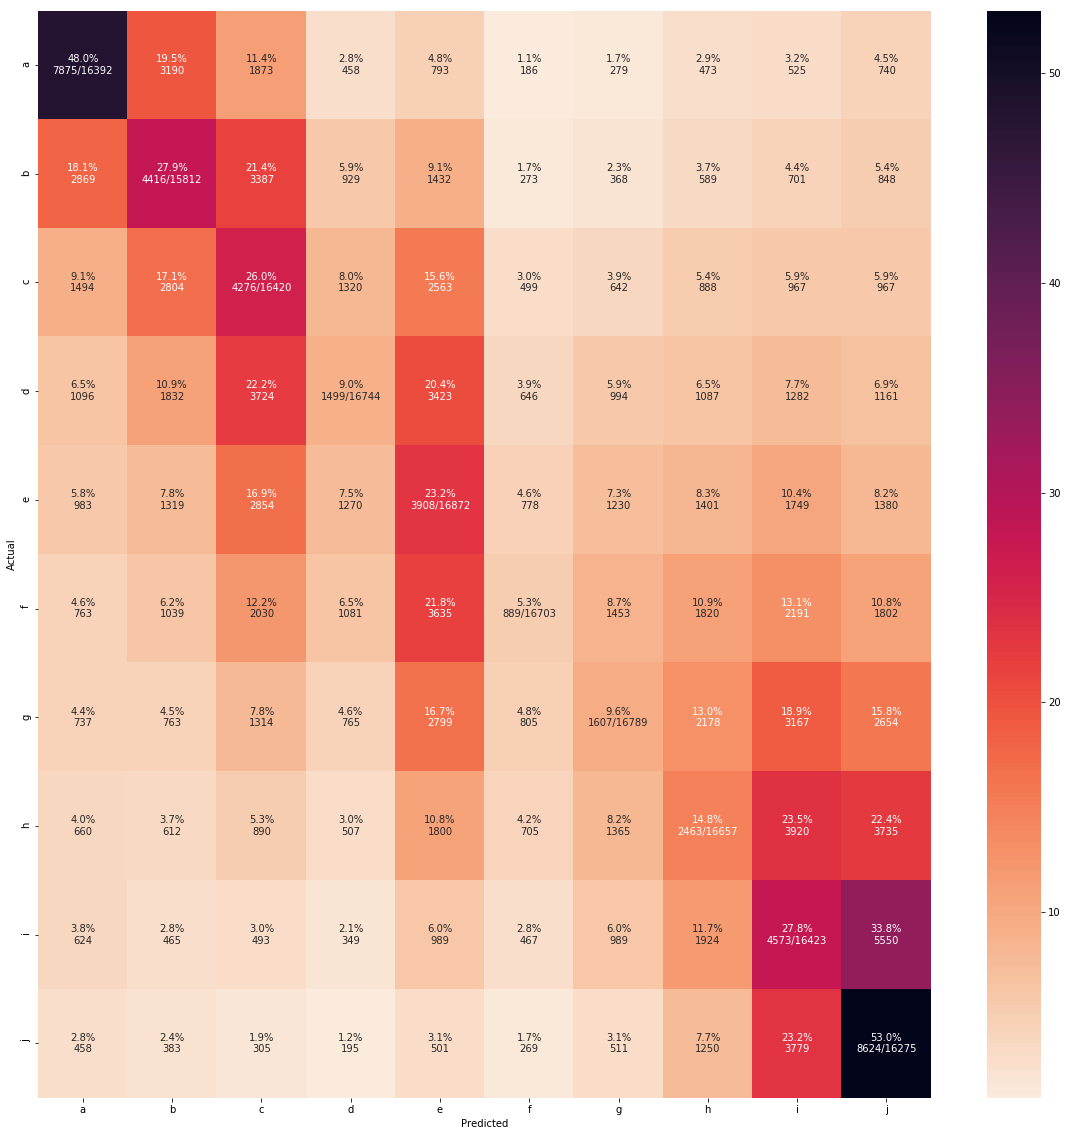

In [50]:
cm_analysis(client_result_final['actual'],client_result_final['valid_preds_names'], list(mapping_dict_cm.values()), ymap=None, figsize=(20,20))